# Repeater spectral analysis

In [1]:
%matplotlib inline

In [2]:
import pylab as pl
import numpy as np
import rtpipe

2016-10-27 11:36:57,493 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



In [3]:
snrdet = {'57623': 35.2, '57633_scan7': 119.3, '57633_scan13': 16.3, '57638': 9.9, '57643': 69.9,
         '57645': 11.1, '57646': 16.0, '57648': 17.6, '57649': 25.2}

## Functions to read and analyze data

In [4]:
def read_ddcut(sdmfile, scan, gainfile=None, i=0):
    if not gainfile:
        gainfile = '.'.join(sdmfile.split('.')[:-1] + ['GN'])

    st = rtpipe.RT.set_pipeline(sdmfile, scan, dmarr=[0], dtarr=[1], flaglist=[], uvoversample=1.5,
                                gainfile=gainfile)
    
    im, data = rtpipe.RT.pipeline_reproduce(st, candloc=[0,i,0,0,0], product='imdata')

    return (im, data)
    
def plot_data(im, data, key, i=0):
    print('Image SNR={0}. Original SNR={1}'.format(im.max()/im.std(), snrdet[key]))
    pl.figure(figsize=(15,8))
    pl.subplot(121)
    if i >= 0:
        data = data[i]
    else:
        data = data.mean(axis=0)
    pl.plot(data[:,0], 'c.')
    pl.plot(data[:,1], 'y.')
    pl.subplot(122)
    pl.imshow(im, interpolation='nearest', cmap='viridis')
    pl.colorbar()

In [5]:
import scipy.stats
from scipy.optimize import curve_fit

def norm(x, a, loc, scale):
    return a*scipy.stats.norm(loc, scale).pdf(x)

def fitandplot(spectra, popt_fixed=None, axis=()):
    specRR = spectra[...,0].real
    specLL = spectra[...,1].real
    nch = len(specRR)
    
    if not popt_fixed:
        bounds = ([1, 0, 10], [2000, 200, 100])
        popt, pcov = curve_fit(norm, np.arange(nch), specRR+specLL, bounds=bounds)
    else:
        popt = popt_fixed

    print(popt)
        
    normsol = norm(np.arange(nch), *popt)

    pl.figure(figsize=(15,7))
    pl.subplot(211)
    pl.errorbar(range(nch), specRR, fmt='c.', ecolor='c')
    pl.errorbar(range(nch), specLL, fmt='y.', ecolor='y')
    pl.plot(np.arange(nch), normsol, 'k')
    pl.xlim(0, nch)
    pl.ylabel('Flux and model')

    pl.subplot(212)
    pl.errorbar(range(nch), (specRR-normsol), fmt='c.', ecolor='c')
    pl.errorbar(range(nch), (specLL-normsol), fmt='y.', ecolor='y')
    #pl.plot(np.arange(nch), stokesI-normpdf, 'k.')
    pl.xlim(0,nch)
    if len(axis):
        pl.axis(axis)
    pl.xlabel('Channel')
    pl.ylabel('Flux-model')

    return spectra-normsol[:,None]

def calc_auto(spec):
    spec_out = np.zeros(shape=len(spec)/2)
    spec_out[0] = np.mean(spec*spec)
    for i in range(1, len(spec)/2):
        spec_out[i] = np.mean(spec[:-i]*spec[i:])
    return spec_out

def plot_auto(spectra):
    print('(RR-LL)/(RR+LL): {0}'.format(np.mean((spectra[:,0]-spectra[:,1])).real/np.mean((spectra[:,0]+spectra[:,1])).real))
    pl.figure(figsize=(15,7))
    pl.subplot(121)
    pl.plot(calc_auto(spectra[:,0]), 'c.')
    pl.plot(calc_auto(spectra[:,1]), 'y.')
    pl.xlim(-1,64)
    pl.xlabel('delta_channel')
    pl.ylabel('auto correlation')
    pl.subplot(122)
    i=1
    pl.scatter(spectra[:-i,0], spectra[i:,0], marker='.', color='c')
    pl.scatter(spectra[:-i,1], spectra[i:,1], marker='.', color='y')
    pl.xlabel('Ch i')
    pl.ylabel('Ch i+1')
    pl.axis('equal')

In [6]:
imdata = {}

In [7]:
imdata['57623'] = read_ddcut('16A-459_TEST_1hr.57623.72670021991.ddcut2', 6, i=1)

2016-10-27 11:37:05,382 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:37:05,383 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:37:05,383 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:37:05,384 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:37:05,385 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr.57623.72670021991.GN
2016-10-27 11:37:05,698 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2016-10-27 11:37:06,073 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2016-10-27 11:37:06,214 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 6 of source FRB121102-off
2016-10-27 11:37:06,726 - rtpipe.parsesdm - INFO - 

2016-10-27 11:37:06,726 - rtpipe.parsesdm - INFO - Metadata summary:
2016-10-27 11:37:06,727 - rtpi

Gridded 1.000 of data. Scaling fft by = 50.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"


2016-10-27 11:37:28,645 - rtpipe - INFO - Made image with SNR min, max: -5.3, 37.3
2016-10-27 11:37:28,700 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [8]:
imdata['57633_scan7'] = read_ddcut('16A-459_TEST_1hr_000.57633.66130137732.scan7.ddcut', 7, 
                                   gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN', i=0)

2016-10-27 11:37:28,765 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:37:28,765 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:37:28,766 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:37:28,767 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:37:28,768 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-10-27 11:37:29,161 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
2016-10-27 11:37:29,598 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
2016-10-27 11:37:29,741 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 7 of source FRB121102-off
2016-10-27 11:37:29,933 - rtpipe.parsesdm - INFO - 

2016-10-27 11:37:29,934 - rtpipe.parsesdm - INFO - Metadata summary:
2016-10-27 11:37:29,935 - 

Gridded 1.000 of data. Scaling fft by = 56.1
Pixel sizes (1.4", 1.1"), Field size 1983.3"


2016-10-27 11:37:51,421 - rtpipe - INFO - Made image with SNR min, max: -5.4, 118.6
2016-10-27 11:37:51,483 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [9]:
imdata['57633_scan13'] = read_ddcut('16A-459_TEST_1hr_000.57633.66130137732.scan13.ddcut2', 13, 
                                    gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN', i=2)

2016-10-27 11:37:51,528 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:37:51,529 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:37:51,530 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:37:51,531 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:37:51,532 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-10-27 11:37:51,778 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
2016-10-27 11:37:52,125 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
2016-10-27 11:37:52,218 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 13 of source FRB121102-off
2016-10-27 11:37:52,377 - rtpipe.parsesdm - INFO - 

2016-10-27 11:37:52,378 - rtpipe.parsesdm - INFO - Metadata summary:
2016-10-27 11:37:52,380 - r

Gridded 1.000 of data. Scaling fft by = 49.9
Pixel sizes (1.5", 1.1"), Field size 1983.3"


2016-10-27 11:38:15,175 - rtpipe - INFO - Made image with SNR min, max: -5.1, 8.3
2016-10-27 11:38:15,231 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [10]:
imdata['57638'] = read_ddcut('16A-496_sb32698778_1_02h00m.57638.42695471065.ddcut', 29)

2016-10-27 11:38:15,275 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:38:15,276 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:38:15,277 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:38:15,278 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:38:15,279 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57638.42695471065.GN
2016-10-27 11:38:16,322 - rtpipe.parsesdm - WARNING - No BDF found for scans [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32]
2016-10-27 11:38:17,179 - rtpipe.parsesdm - WARNING - No BDF found for scans [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32]
2016-10-27 11:38:17,417 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source FRB121102-off
2016-10-27 11:38:17,707 - rtpipe.parsesdm - IN

Gridded 1.000 of data. Scaling fft by = 161.6
Pixel sizes (1.1", 0.5"), Field size 1983.3"


2016-10-27 11:38:52,097 - rtpipe - INFO - Made image with SNR min, max: -5.4, 12.1
2016-10-27 11:38:52,237 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [11]:
imdata['57643'] = read_ddcut('16A-496_sb32698778_1_02h00m_001.57643.38562630787.ddcut2', 29, i=2)

2016-10-27 11:38:52,277 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:38:52,278 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:38:52,279 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:38:52,280 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:38:52,281 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57643.38562630787.GN
2016-10-27 11:38:52,765 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-10-27 11:38:53,467 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-10-27 11:38:53,689 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source 

Gridded 1.000 of data. Scaling fft by = 248.0
Pixel sizes (0.9", 0.5"), Field size 1983.3"


2016-10-27 11:39:38,086 - rtpipe - INFO - Made image with SNR min, max: -5.3, 31.1
2016-10-27 11:39:38,382 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [12]:
imdata['57645'] = read_ddcut('16A-496_sb32698778_1_02h00m.57645.38915079861.ddcut2', 16, i=1)

2016-10-27 11:39:38,431 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:39:38,432 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:39:38,433 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:39:38,434 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:39:38,435 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57645.38915079861.GN
2016-10-27 11:39:38,893 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
2016-10-27 11:39:39,650 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
2016-10-27 11:39:39,901 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 16 of source FRB1

Gridded 1.000 of data. Scaling fft by = 336.5
Pixel sizes (0.5", 0.5"), Field size 1983.3"


2016-10-27 11:40:33,198 - rtpipe - INFO - Made image with SNR min, max: -5.1, 9.2
2016-10-27 11:40:33,621 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [13]:
imdata['57646'] = read_ddcut('16A-496_sb32698778_1_02h00m_000.57646.38643644676.ddcut2', 32, i=1)

2016-10-27 11:40:33,733 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:40:33,735 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:40:33,737 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:40:33,739 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:40:33,741 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57646.38643644676.GN
2016-10-27 11:40:34,334 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]
2016-10-27 11:40:35,084 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]
2016-10-27 11:40:35,323 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 32 of source 

Gridded 1.000 of data. Scaling fft by = 377.8
Pixel sizes (0.5", 0.5"), Field size 1983.3"


2016-10-27 11:41:36,848 - rtpipe - INFO - Made image with SNR min, max: -5.2, 18.8
2016-10-27 11:41:37,194 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [14]:
imdata['57648'] = read_ddcut('16A-496_sb32698778_1_02h00m_000.57648.37452900463.ddcut2', 25, i=1)

2016-10-27 11:41:37,268 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:41:37,269 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:41:37,271 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:41:37,272 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:41:37,273 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57648.37452900463.GN
2016-10-27 11:41:37,812 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]
2016-10-27 11:41:38,593 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]
2016-10-27 11:41:38,845 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 25 of source 

Gridded 1.000 of data. Scaling fft by = 336.5
Pixel sizes (0.5", 0.5"), Field size 1983.3"


2016-10-27 11:42:31,377 - rtpipe - INFO - Made image with SNR min, max: -5.6, 22.5
2016-10-27 11:42:31,696 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


In [15]:
imdata['57649'] = read_ddcut('16A-496_sb32698778_1_02h00m_001.57649.37461215278.ddcut2', 31, i=1)

2016-10-27 11:42:31,764 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to []
2016-10-27 11:42:31,765 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [0]
2016-10-27 11:42:31,767 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-10-27 11:42:31,768 - rtpipe.parsesdm - INFO - Setting (standard) key uvoversample to 1.5
2016-10-27 11:42:31,769 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57649.37461215278.GN
2016-10-27 11:42:32,264 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33]
2016-10-27 11:42:33,018 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33]
2016-10-27 11:42:33,260 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 31 of source 

Gridded 1.000 of data. Scaling fft by = 382.8
Pixel sizes (0.5", 0.5"), Field size 1983.3"


2016-10-27 11:43:34,938 - rtpipe - INFO - Made image with SNR min, max: -6.0, 34.2
2016-10-27 11:43:35,271 - rtpipe - INFO - Rephasing data to (l, m)=(-0.0004, 0.0005).


## Model spectral structure and calculate autocorrelations

[3, 70, 40]
(RR-LL)/(RR+LL): -0.0316556729376


2016-10-27 11:43:35,582 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:35,583 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:35,699 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)



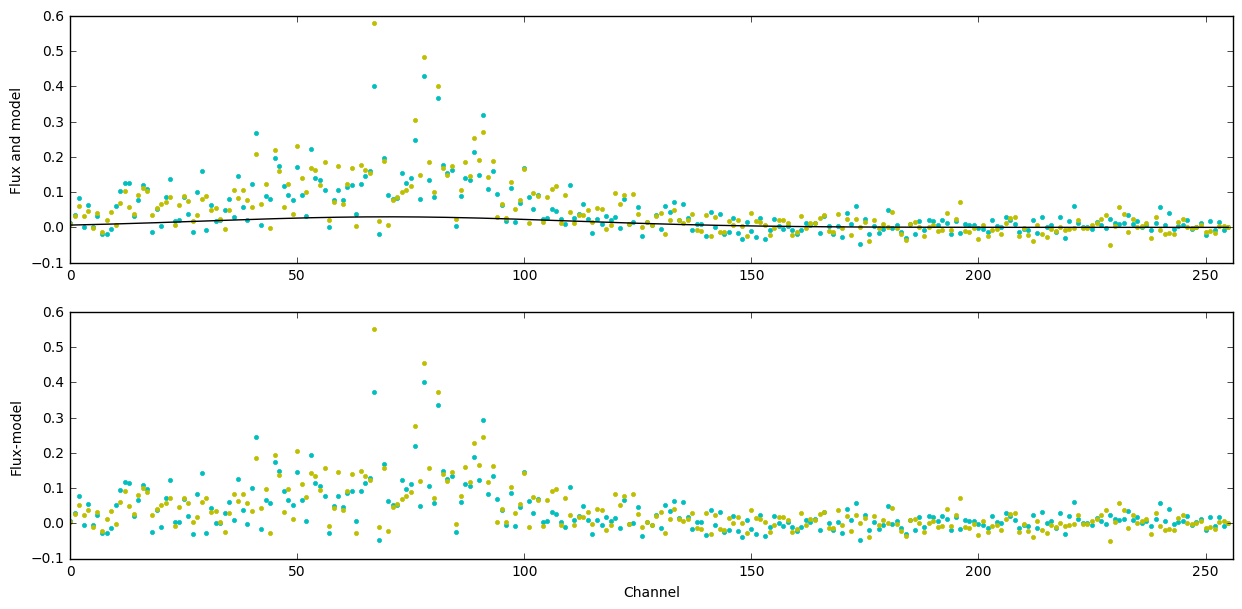

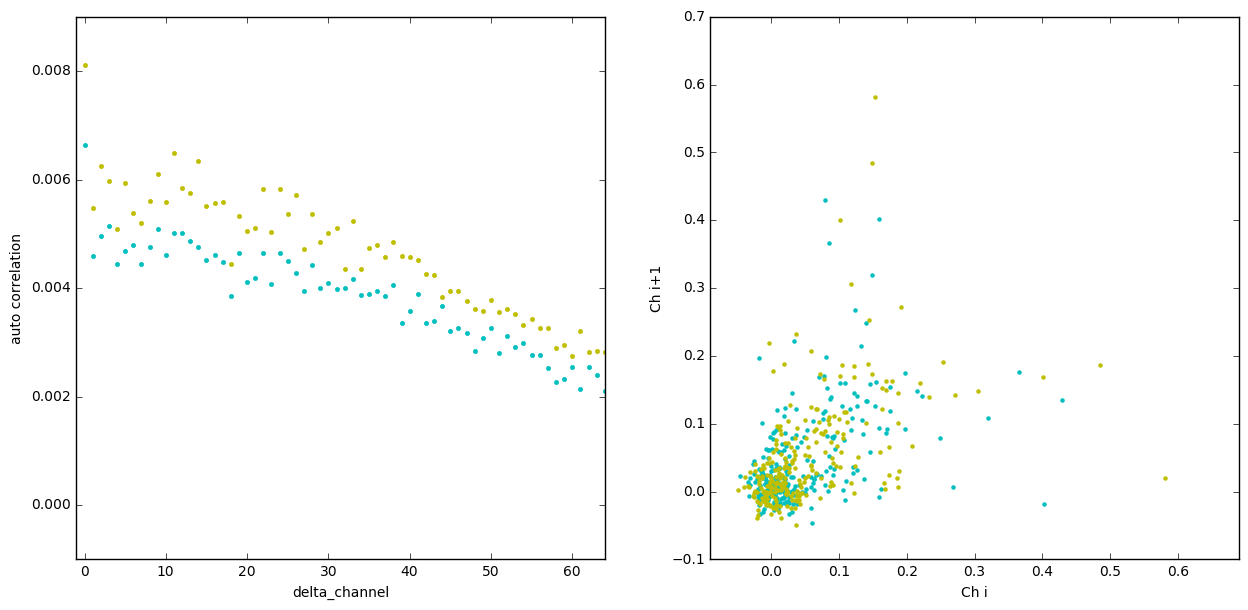

In [16]:
key = '57623'
im, data = imdata[key]
spectra = data[1]

popt_nosub = [3, 70, 40]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

In [17]:
circsum = np.zeros(shape=(256), dtype=float)
circfftsum = np.zeros(shape=(128), dtype=float)

[20, 160, 80]


2016-10-27 11:43:37,650 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:37,651 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



(RR-LL)/(RR+LL): -0.00613375846297


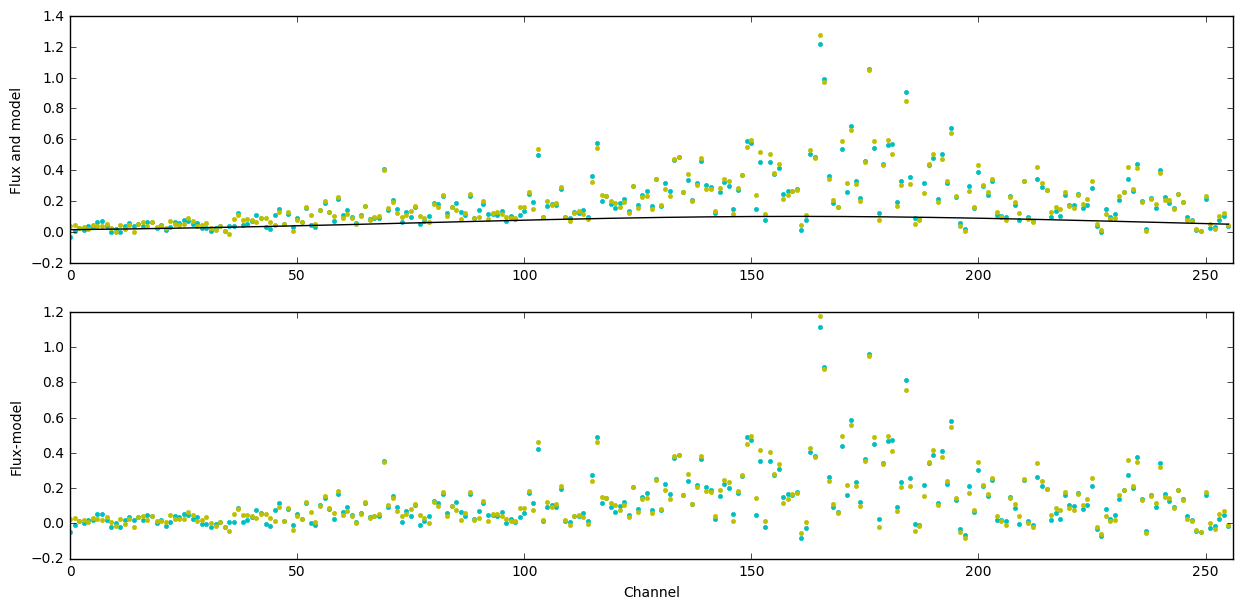

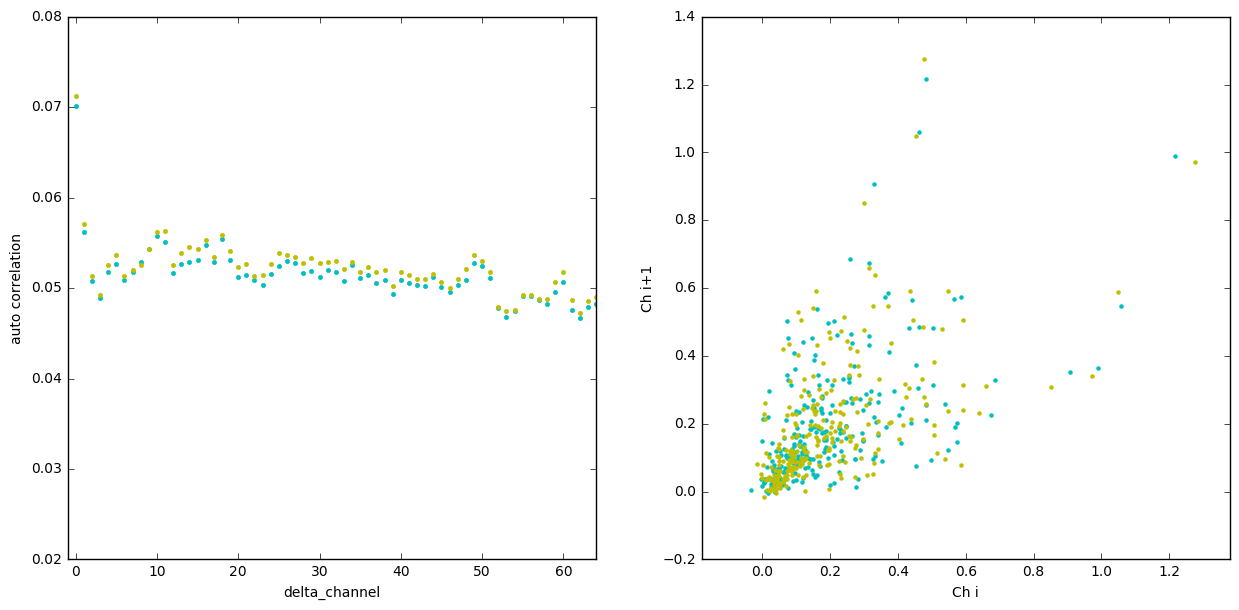

In [18]:
key = '57633_scan7'
im, data = imdata[key]
spectra = data[:2].mean(axis=0)

popt_nosub = [20, 160, 80]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

2016-10-27 11:43:39,370 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:39,371 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



[2, 0, 30]
(RR-LL)/(RR+LL): -0.0338710658252


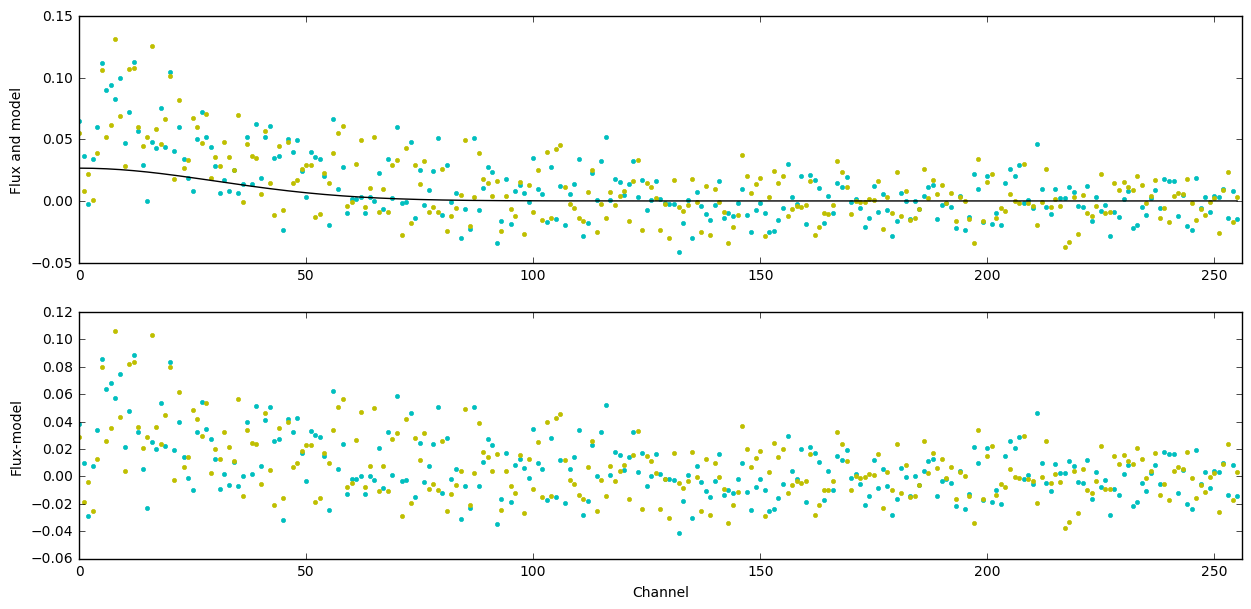

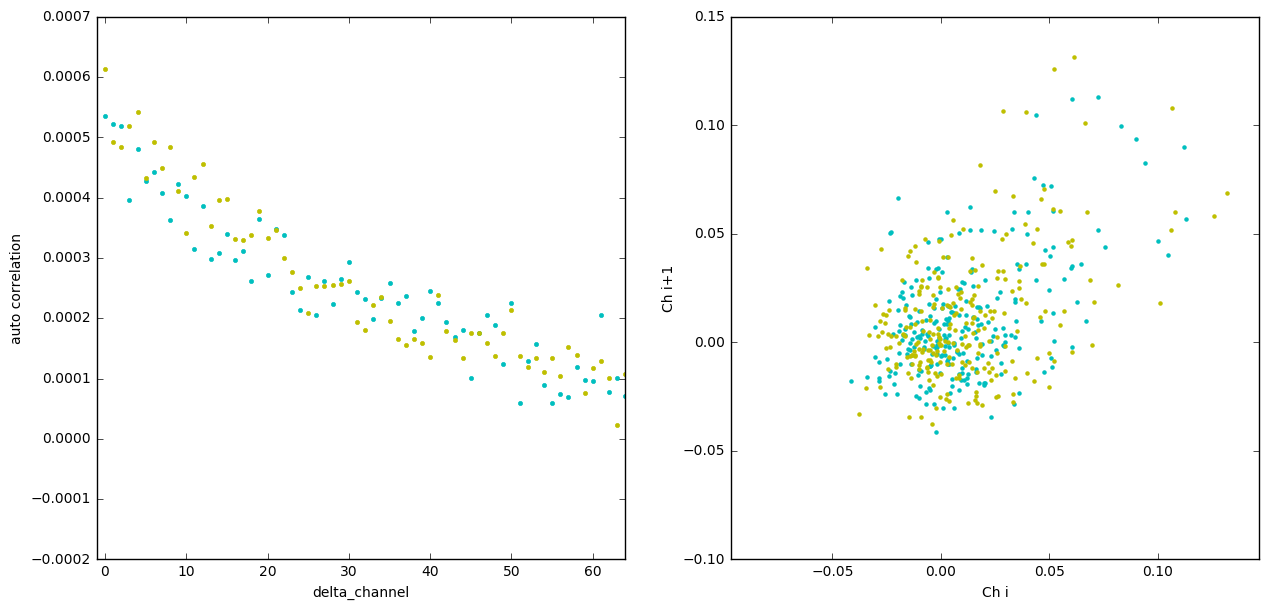

In [19]:
key = '57633_scan13'
im, data = imdata[key]
spectra = data[1:3].mean(axis=0)

popt_nosub = [2, 0, 30]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

2016-10-27 11:43:41,719 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:41,720 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



[2, 150, 40]
(RR-LL)/(RR+LL): 0.0503429956734


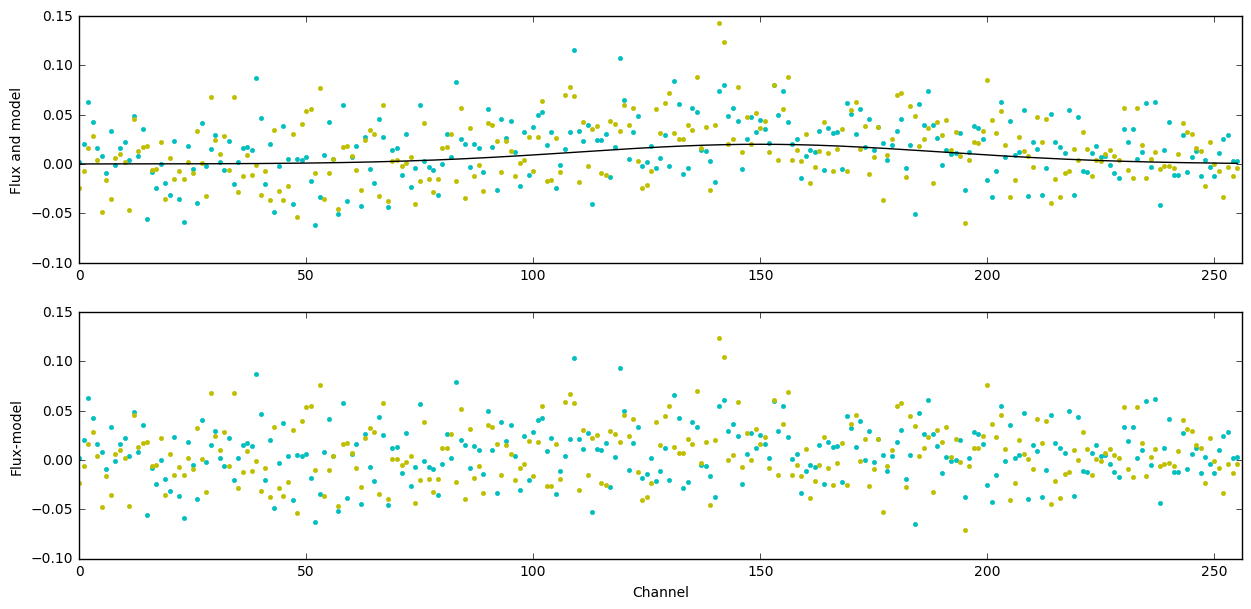

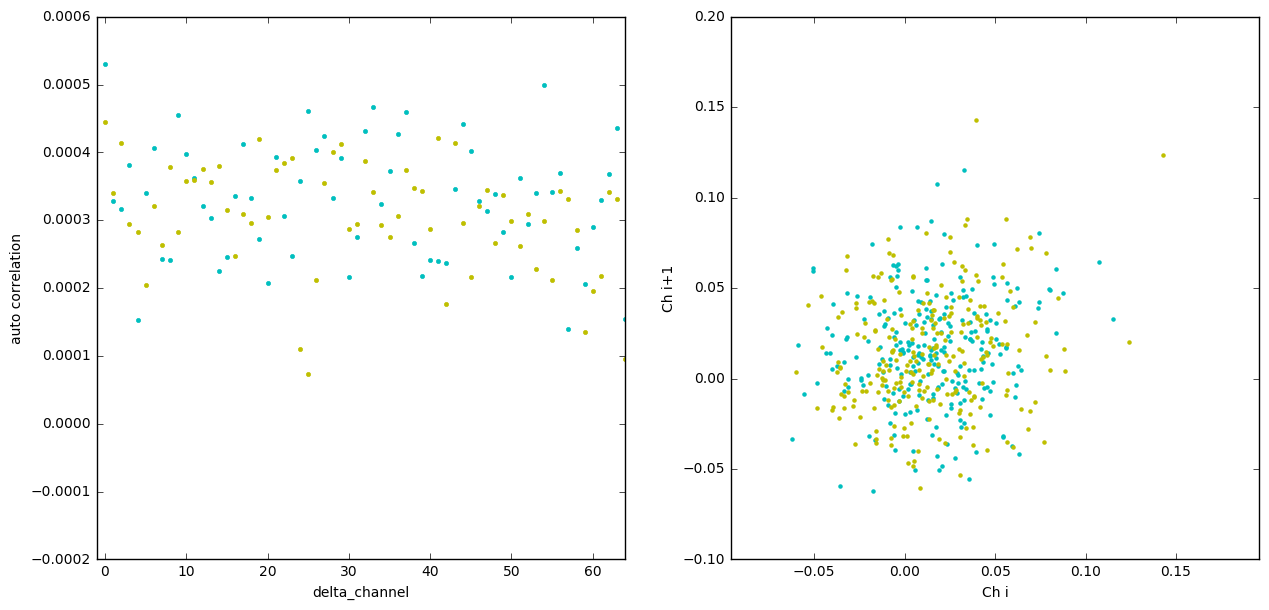

In [20]:
key = '57638'
im, data = imdata[key]
spectra = data.mean(axis=0)

popt_nosub = [2, 150, 40]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

2016-10-27 11:43:43,418 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:43,419 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



[10, 80, 60]
(RR-LL)/(RR+LL): 0.0163138341159


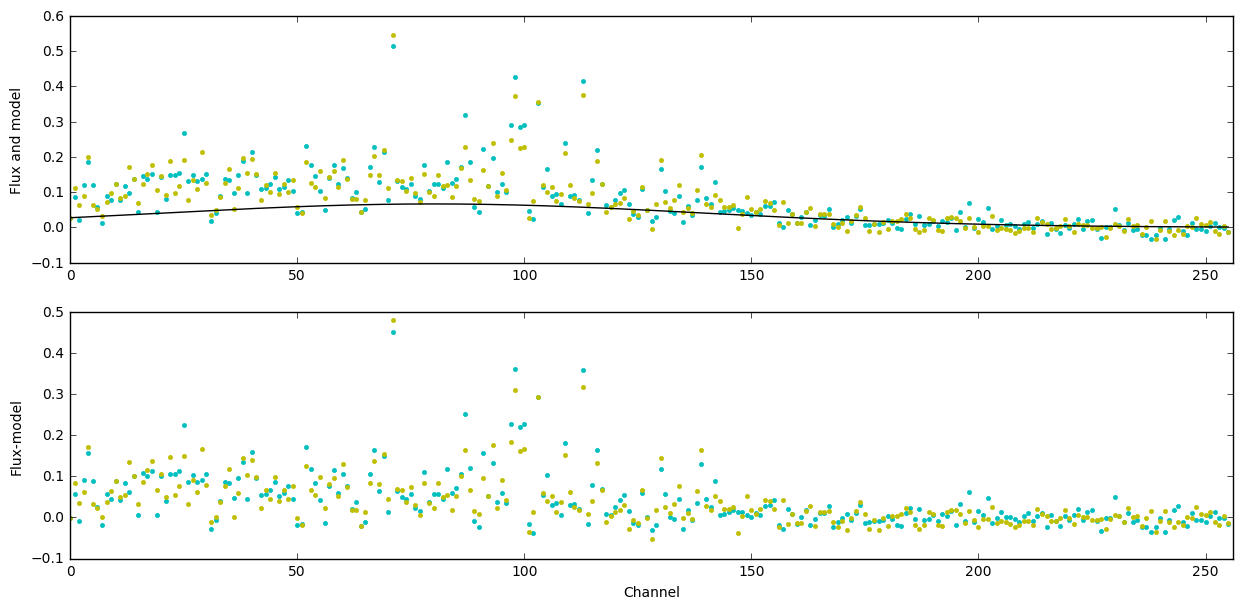

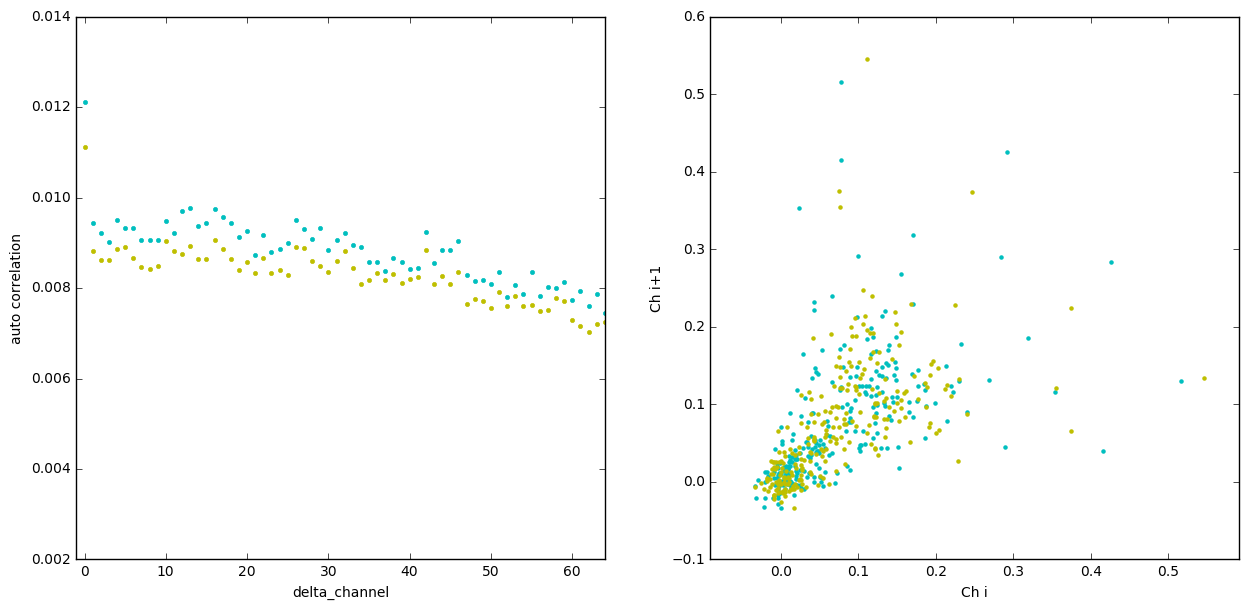

In [21]:
key = '57643'
im, data = imdata[key]
spectra = data[1:].mean(axis=0)

popt_nosub = [10, 80, 60]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

2016-10-27 11:43:45,205 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:45,206 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



[3, 100, 50]
(RR-LL)/(RR+LL): -0.00275518395938


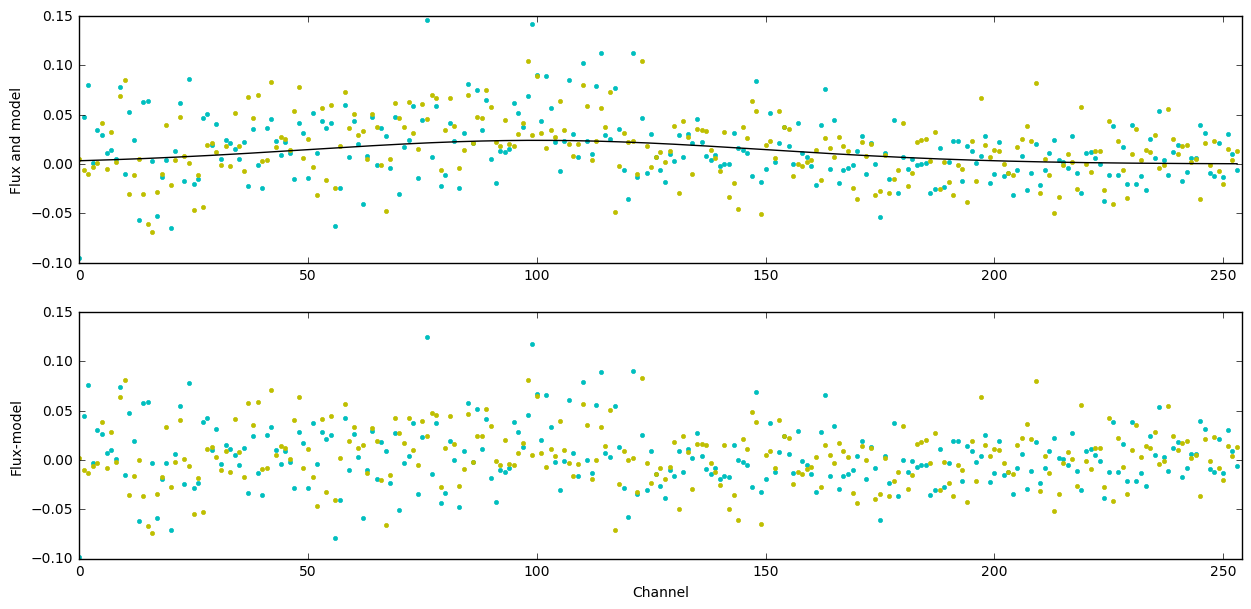

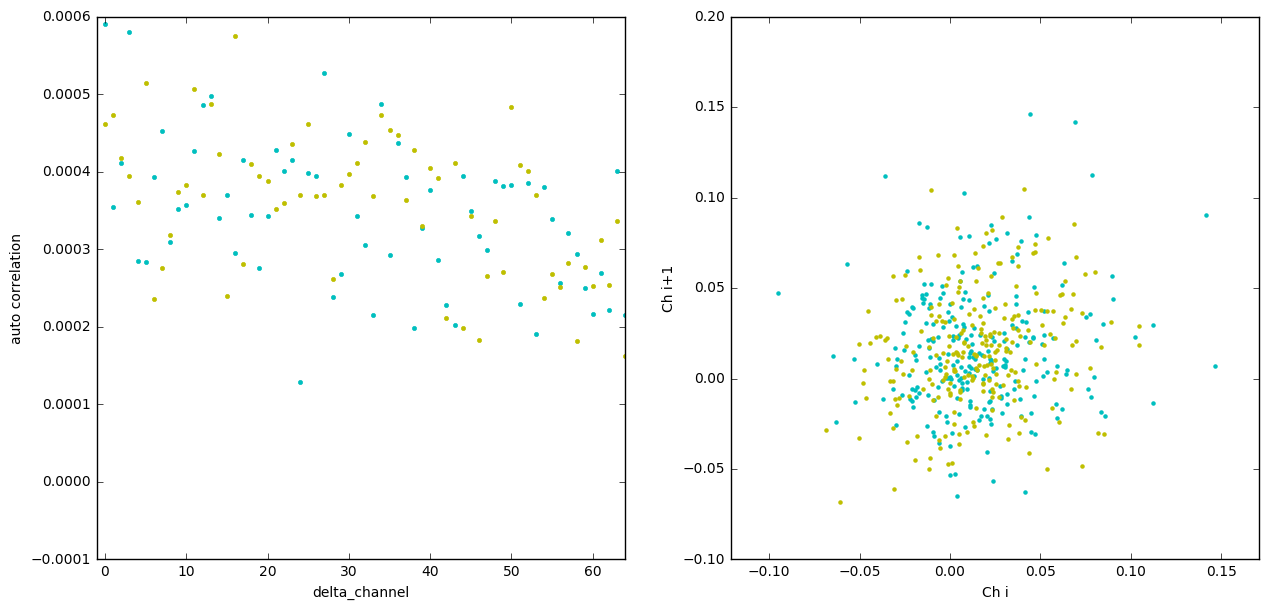

In [22]:
key = '57645'
im, data = imdata[key]
spectra = data[1,2:]

popt_nosub = [3, 100, 50]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

2016-10-27 11:43:47,293 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:47,294 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



[5, 10, 40]
(RR-LL)/(RR+LL): -0.0171384233981


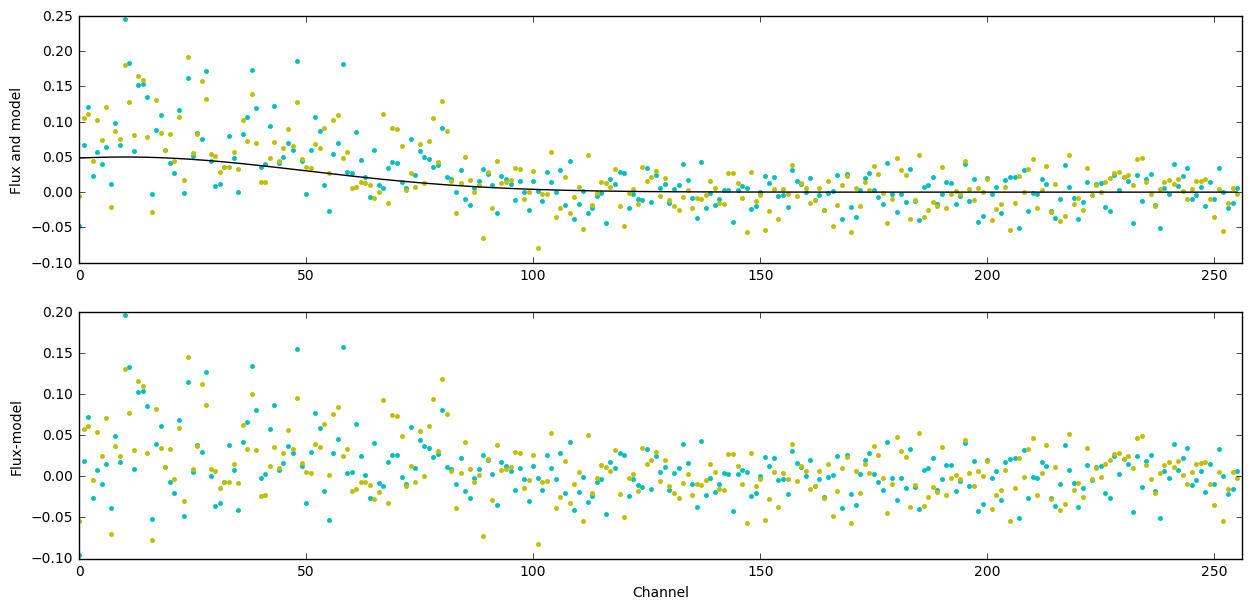

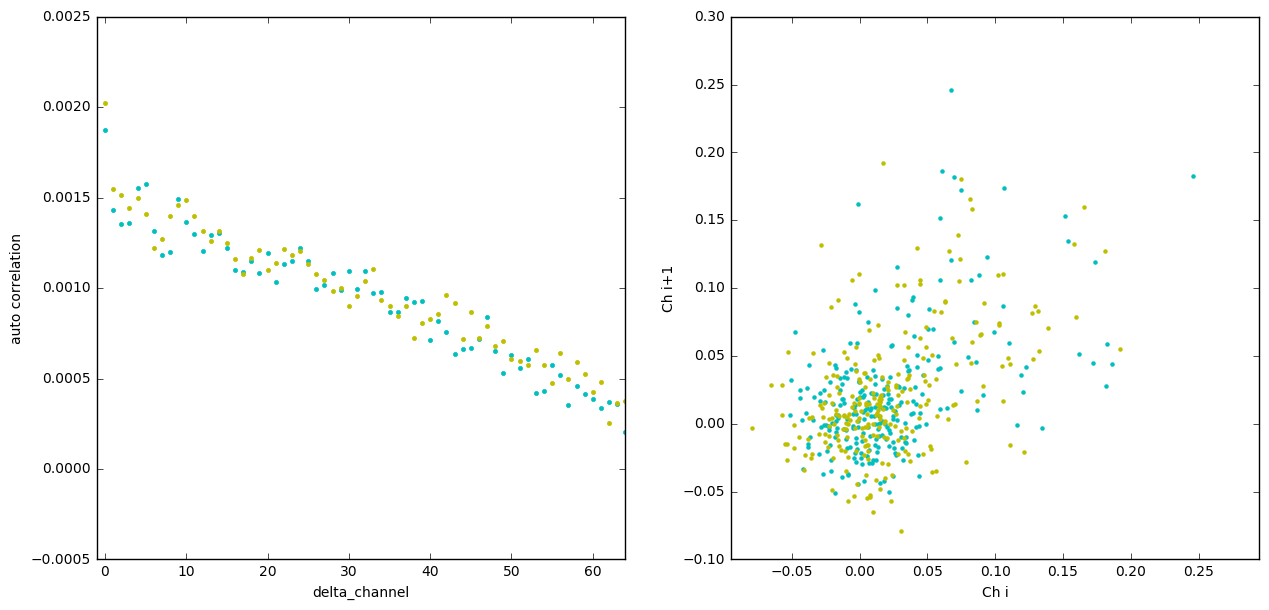

In [23]:
key = '57646'
im, data = imdata[key]
spectra = data[1]

popt_nosub = [5, 10, 40]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

2016-10-27 11:43:49,219 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:49,220 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



[3, 100, 50]
(RR-LL)/(RR+LL): -0.0101413549855


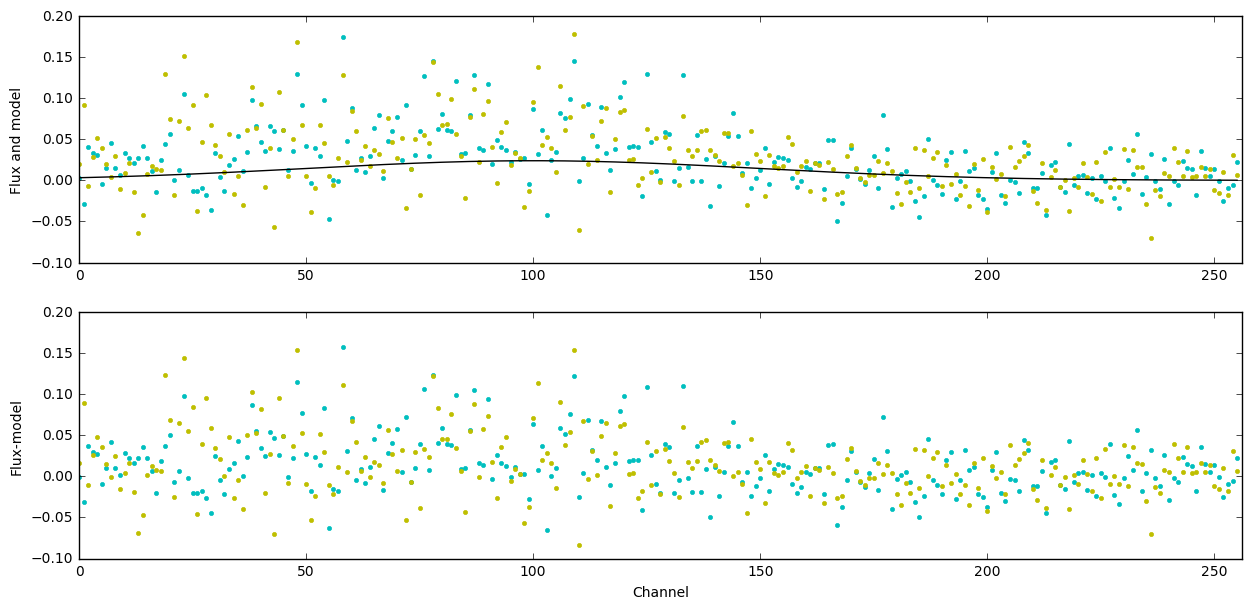

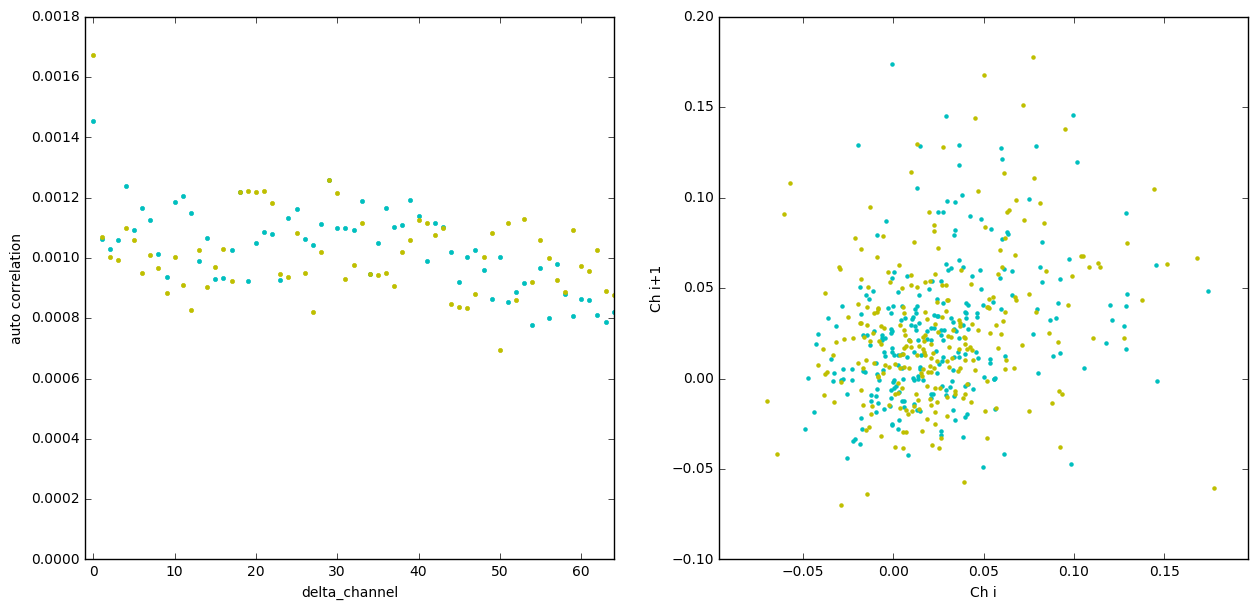

In [24]:
key = '57648'
im, data = imdata[key]
spectra = data[1]

popt_nosub = [3, 100, 50]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

[5, 120, 80]
(RR-LL)/(RR+LL): -0.0031608287245


2016-10-27 11:43:51,251 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part

2016-10-27 11:43:51,252 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part



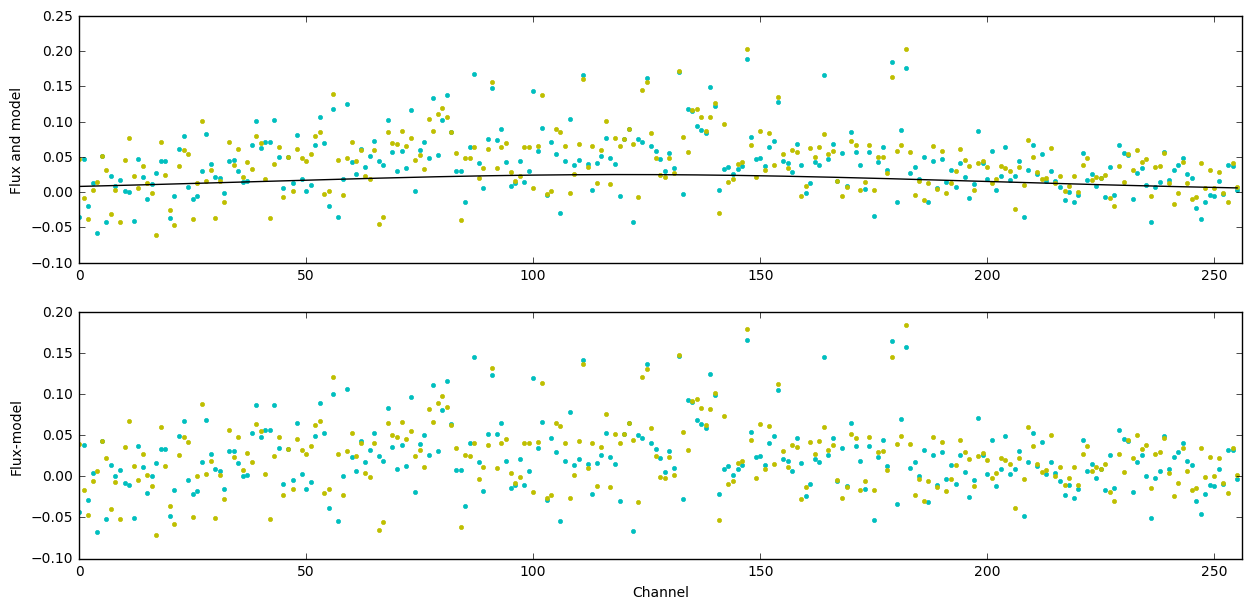

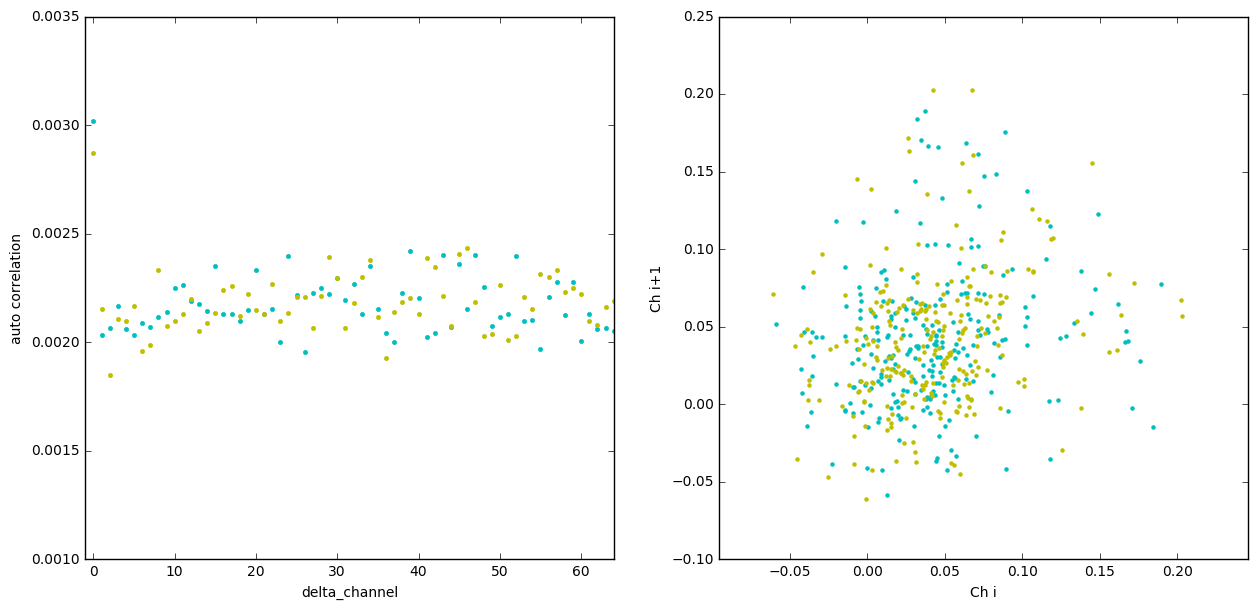

In [25]:
key = '57649'
im, data = imdata[key]
spectra = data[1]

popt_nosub = [5, 120, 80]
spectra_sub = fitandplot(spectra, popt_fixed=popt_nosub)
plot_auto(spectra)

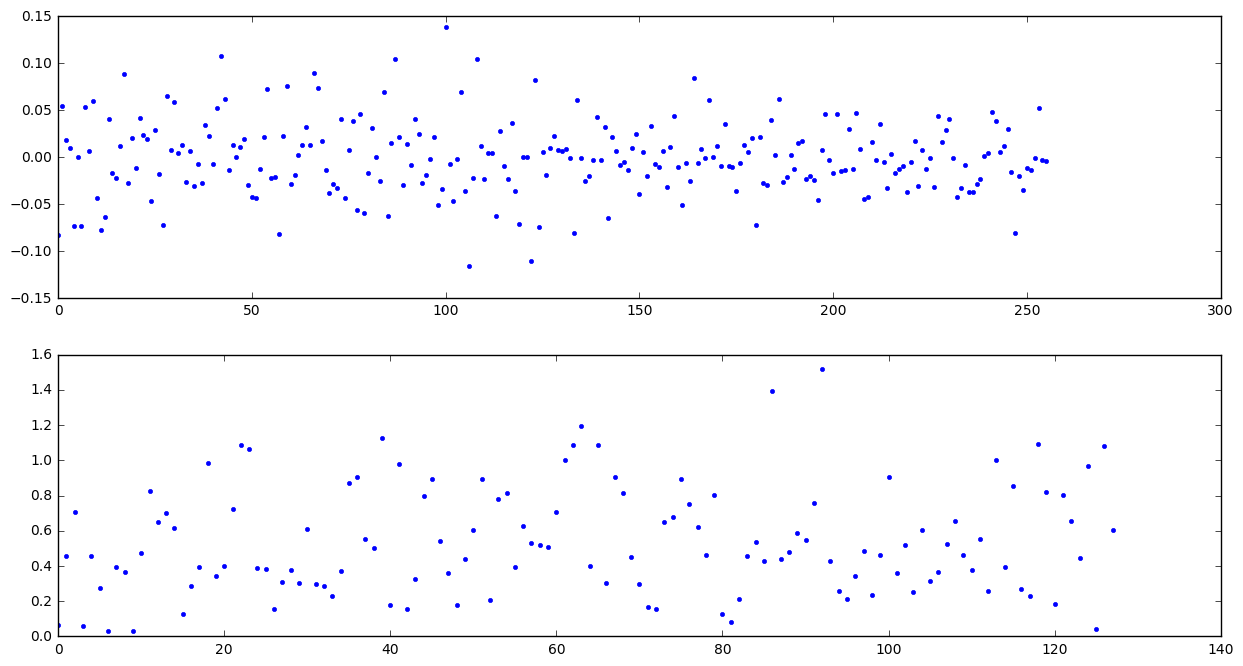

In [26]:
circ = spectra[:,0].real - spectra[:,1].real
pl.figure(figsize=(15,8))
pl.subplot(211)
pl.plot(circ,'.')
pl.subplot(212)
circfft = np.abs(np.fft.fft(circ)[:128])
pl.plot(circfft, '.')